In [16]:
import sys
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gym

from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD

In [17]:
# *******************************************************************************************
# Random seeds for reproducibility

# _seeds = np.random.randint(low = 0, high = 100, size = (3, 4))
# print(_seeds)

# Produced seeds:
# [[87 32 19 47]
#  [69 92  6 65]
#  [36 84 36 44]]

In [18]:
# *******************************************************************************************
# Environment Initialization

env = gym.make('CartPole-v0')

random.seed(87)
np.random.seed(32)
tf.set_random_seed(19)
env.seed(47)

state_size  = env.observation_space.shape[0]
action_size = env.action_space.n

print("Obseravtion spapce size: {}".format(state_size))
print("Action space size: {}".format(action_size))

Obseravtion spapce size: 4
Action space size: 2


In [19]:
# *******************************************************************************************
# Algorithm Parameters

n_episodes     = 5000
batch_size     = 8
total_steps    = 1e6
print_interval = 100

In [20]:
# *******************************************************************************************
# CLASS

class Agent:  
    def __init__(self, state_size, action_size):
        
# ********************************
# Parameters 

        self.state_size    = state_size
        self.action_size   = action_size
        self.counter       = 0
        self.eval_interval = 200
        self.epsilon       = 1.0
        self.epsilon_min   = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.alpha         = 0.001     

        self.loss1         = list()
        self.loss2         = list()
        
# ********************************
# Memories

        self.memory_tape = deque(maxlen=20000)
        self.memory_full = deque(maxlen=None)
        self.state_memory = deque(maxlen=20000)
        self.memory_episode = deque(maxlen=200)    
        self.horizon = deque (maxlen = 4)

        self.reward_string = self.build_reward_string()
#         plt.plot(self.reward_string) # This is to plot the credit assignment string
#         plt.show()

# ********************************
# Models

        self.model      = self.build_model()
        self.model_eval = self.build_network_eval()
        
# *******************************************************************************************
# FUNCTIONS

# ********************************
# Neural Networks

    def build_network(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( state_size , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn
    
    def build_model(self):
        model = list()
        for i in range(action_size):
            model.append(self.build_network())
        return model
    
    def build_network_eval(self):
        nn = Sequential()
        nn.add(Dense(16, input_dim = state_size , activation='relu'))
        nn.add(Dense(16, activation='relu'))
        nn.add(Dense( 1 , activation='linear'))
        nn.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return nn

# ********************************
# Replay Buffer

    def remember_tape(self, state, action, next_state):
        self.memory_tape.append((state, action, next_state)) 
        self.horizon.append((state, action))
              
    def remember_episode(self, state, action, next_state):
        self.memory_episode.append((state, action, next_state)) 
        
# ********************************
# Policy

    def act(self, state):
#         TODO: This is manual now,
#         instead of two separate networks, a network and output of action_size should be used
        if np.random.rand() <= self.epsilon:
            act = np.random.randint(2)
            return act
        
        self.future = list()
        evaluated   = list()
        state       = np.reshape(state, [1,state_size])
            
        predicted_state0 = self.model[0].predict(state)
        predicted_state1 = self.model[1].predict(state)
        eval_state0 = self.evaluate_state(predicted_state0)        
        eval_state1 = self.evaluate_state(predicted_state1)
        evaluated = [eval_state0 , eval_state1]
        
        if eval_state0 == eval_state1:               
            act = np.random.randint(2)
            return act
        
        act = np.argmin(evaluated)
        return act
  
    def evaluate_state(self,state):
        eval = self.model_eval.predict(state)
        return eval
    
# ********************************
# Models   
    def train(self):
        minibatch = random.sample(self.memory_tape, batch_size)
        
        for state, action, next_state in minibatch:
            state = np.reshape(state, [1,state_size])
            next_state = np.reshape(next_state, [1, state_size]) 
            
            self.model[action].fit(state, next_state, epochs=1, verbose=0)
        if (self.counter % self.eval_interval == 0):
            eval_score = self.model[action].evaluate(state, next_state, verbose=1,steps=1)
            
            if action ==0:
                self.loss1.append(eval_score)
            else:
                self.loss2.append(eval_score)            
        self.counter += 1
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def eval_train(self):
#         TODO: Datasets should be combined before learning(fitting)
        temp   = self.memory_episode
        lenght = len(temp)
        temp   = np.reshape(temp, [lenght,3])
        temp   = tuple(temp[:-4])
        temp   = random.sample(temp, 4)
        for state, action, next_state in temp:
            state  = np.reshape(state, [1,state_size])
            reward = self.model_eval.predict(state) * (1-self.alpha)
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0)   
       
        boundary = np.reshape (agent.horizon,[4, 2])
        boundary = np.concatenate((boundary, self.reward_string), axis = 1)
        for state, i, reward in boundary:
            state  = np.reshape(state, [1,state_size])
            reward = self.model_eval.predict(state) * (1-self.alpha) + reward * self.alpha
            
            self.model_eval.fit(state, reward, epochs=1, verbose=0)
            
    def build_reward_string(self):
#         TODO: This is manual now, It is a parameter that should be evaluated
        return np.reshape(np.array([0.25, 0.5, 0.75, 1]),[4,1])

In [21]:
# *******************************************************************************************
# Main 

agent  = Agent(state_size, action_size)

_steps = 0
done   = False
score  = list()

cons_success    = 0
done_in         = n_episodes
render_interval = 25
state_full      = list()

for e in range(n_episodes):
    
    state_episode = np.zeros((1,4))
    state = env.reset()
    agent.state_memory.clear()
    
    for time in range(200):
        
#       if e % render_interval ==0: 
#         env.render(mode="human") 

        action = agent.act(state)
        state_episode = np.concatenate ((state_episode , (np.reshape(state,(1,4)))),axis=0)
        next_state, reward, done, _ = env.step(action)
        _steps += 1
        
        if _steps >= total_steps:
            print("total steps of {} reached".format(total_steps))
            sys.exit()
            
        agent.remember_tape(state, action, next_state)
        agent.remember_episode(state, action, next_state)



        agent.state_memory.append(state)   
        state = next_state
        
        if done:
            if (e % print_interval) == 0:
                print("episode: {}/{}, score: {}, e: {:.2}, total steps: {}".format(e, n_episodes, time, agent.epsilon,_steps))
            
            state_full.append(state_episode)
            
            score.append(time)
            np.savetxt('linear_H4_5.out', score, delimiter=',')
            np.savetxt('linear_H4_5.out', score, fmt='%d')
            
            # to record 100 consecutive success
            if ((len(agent.state_memory)) >= 195):
                consecutive_success += 1
            else:
                consecutive_success = 0
            if consecutive_success == 100:
                done_in = e
                print ("Done in:", done_in-100, "Epidodes -------------------------------------------------------" )
                
            
            
            if ((len(agent.state_memory)) < 198) and ((len(agent.state_memory)) > 8):
                agent.eval_train()

            if len(agent.memory_tape) > batch_size:
                agent.train()
            
            break
            
    agent.state_memory.clear()
    agent.memory_episode.clear()

episode: 0/5000, score: 13, e: 1.0, total steps: 14
1/1 [==============================] - 0s 115ms/step
episode: 100/5000, score: 39, e: 0.37, total steps: 4613
episode: 200/5000, score: 91, e: 0.13, total steps: 17649
1/1 [==============================] - 0s 0us/step
episode: 300/5000, score: 199, e: 0.049, total steps: 36441
episode: 400/5000, score: 199, e: 0.018, total steps: 55389
1/1 [==============================] - 0s 99ms/step
episode: 500/5000, score: 199, e: 0.0099, total steps: 74116
episode: 600/5000, score: 199, e: 0.0099, total steps: 93166
1/1 [==============================] - 0s 997us/step
episode: 700/5000, score: 199, e: 0.0099, total steps: 112871
episode: 800/5000, score: 199, e: 0.0099, total steps: 132806
1/1 [==============================] - 0s 997us/step
episode: 900/5000, score: 199, e: 0.0099, total steps: 152587
episode: 1000/5000, score: 199, e: 0.0099, total steps: 172487
1/1 [==============================] - 0s 998us/step
episode: 1100/5000, score: 

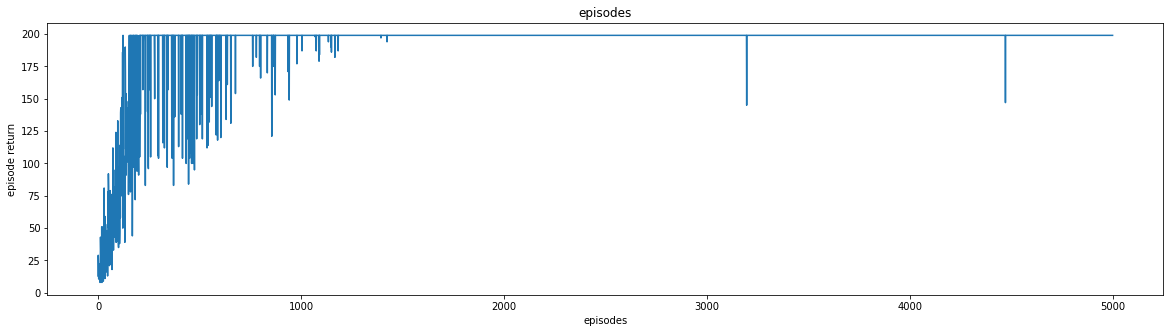

In [35]:
# *******************************************************************************************
# plot the learning curve

fig, ax = plt.subplots()
ax.plot(score)
fig.set_size_inches(20,5)
ax.set_xlabel('episodes')
ax.set_ylabel('episode return')
plt.show()

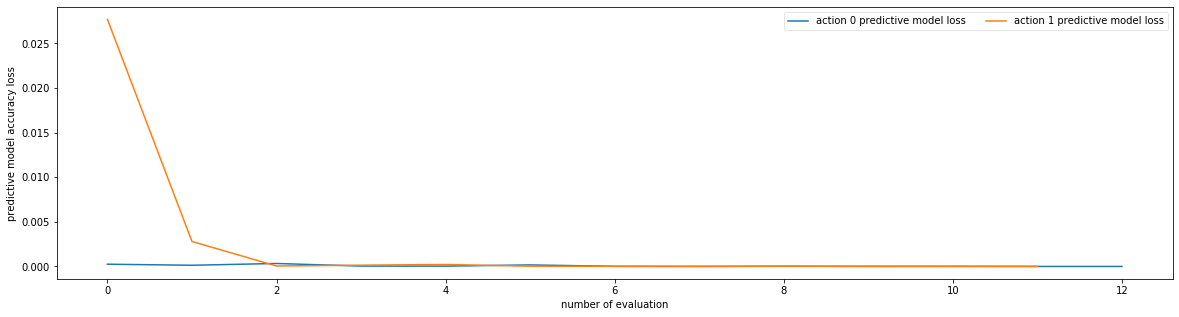

In [43]:
# *******************************************************************************************
# plot the model accuracy

fig, ax = plt.subplots()
plt.plot(agent.loss1, label="action 0 predictive model loss")
plt.plot(agent.loss2, label="action 1 predictive model loss")
fig.set_size_inches(20,5)
ax.set_xlabel('number of evaluation')
ax.set_ylabel('predictive model accuracy loss')
leg = plt.legend(loc='best', ncol=2)
leg.get_frame().set_alpha(0.5)
plt.show()

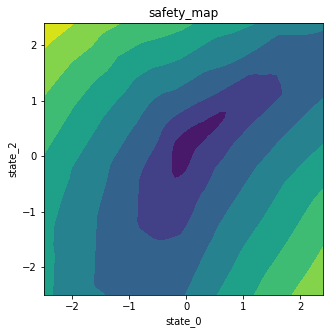

In [46]:
x = np.arange(-2.5, 2.5, 0.1)
y = np.arange(-2.500, 2.500, 0.100)
xx, yy = np.meshgrid(x, y, sparse=True)

# z = np.zeros((np.shape(x)[0],np.shape(y)[0]))
# for i in range(np.shape(x)[0]):
#     for j in range(np.shape(y)[0]):
#         c = [[x[i],0,y[j],0]]
#         z[i,j] = agent.model_eval.predict(np.array(c))

fig, ax = plt.subplots()
plt.contourf(x,y,z)
fig.set_size_inches(5,5)
ax.set_xlabel('state_0')
ax.set_ylabel('state_2')
ax.set_title('safety_map')
plt.show()